# X-learner

In [1]:
import sklearn.utils

def check_matplotlib_support(caller_name):
    try:
        import matplotlib
    except ImportError:
        raise ImportError(
            "Matplotlib is required for plotting functions in " + caller_name
        )

setattr(sklearn.utils, 'check_matplotlib_support', check_matplotlib_support)

In [2]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, CatBoostRegressor

from sklift.datasets import fetch_x5
from sklift.metrics import uplift_auc_score, qini_auc_score
from sklift.viz import plot_uplift_curve, plot_qini_curve
from feature_extraction import UpliftFeatureExtractor

import optuna

## Реализация X-learner

In [3]:
class MyXLearner(BaseEstimator):
    def __init__(self, outcome_learner, effect_learner=None, propensity_learner=None):
        self.outcome_learner = outcome_learner
        self.effect_learner = effect_learner 
        self.propensity_learner = propensity_learner if propensity_learner else LogisticRegression()
        
        self.model_mu_0 = None # outcome model (control)
        self.model_mu_1 = None # outcome model (treatment)
        self.model_tau_0 = None # effect model (control side)
        self.model_tau_1 = None # effect model (treatment side)
        self.model_propensity = None 

    def fit(self, X, y, treatment):
        # разделение данных
        X_c = X[treatment == 0]
        y_c = y[treatment == 0]
        X_t = X[treatment == 1]
        y_t = y[treatment == 1]

        self.model_mu_0 = clone(self.outcome_learner)
        self.model_mu_0.fit(X_c, y_c)
        
        self.model_mu_1 = clone(self.outcome_learner)
        self.model_mu_1.fit(X_t, y_t)

        self.model_propensity = clone(self.propensity_learner)
        self.model_propensity.fit(X, treatment)

        # D_0 = mu_1(X_c) - y_c
        # D_1 = y_t - mu_0(X_t)
        mu_1_pred_on_c = self.model_mu_1.predict_proba(X_c)[:, 1] 
        D_0 = mu_1_pred_on_c - y_c 
        
        mu_0_pred_on_t = self.model_mu_0.predict_proba(X_t)[:, 1]
        D_1 = y_t - mu_0_pred_on_t 

        self.model_tau_0 = clone(self.effect_learner)
        self.model_tau_0.fit(X_c, D_0)
        
        self.model_tau_1 = clone(self.effect_learner)
        self.model_tau_1.fit(X_t, D_1)
        
        return self

    def predict(self, X):
        tau_0_pred = self.model_tau_0.predict(X)
        tau_1_pred = self.model_tau_1.predict(X)
        
        # веса (пропенсити скор)
        g_x = self.model_propensity.predict_proba(X)[:, 1]
        
        # tau(x) = g(x)*tau_0(x) + (1-g(x))*tau_1(x)
        uplift = g_x * tau_0_pred + (1 - g_x) * tau_1_pred
        return uplift
    
    @property
    def cate_models_(self):
        return [self.model_tau_0, self.model_tau_1]

## Подготовка данных

In [4]:
dataset = fetch_x5()
data = dataset.data

In [5]:
# подсчет фич
extractor = UpliftFeatureExtractor(drop_redundant=True)
df = extractor.calculate_features(
    clients_df=data.clients,
    train_df=data.train,
    treatment_df=dataset.treatment,
    target_df=dataset.target,
    purchases_df=data.purchases
)

del data
gc.collect()

features = extractor.feature_names

print(f"Создано признаков: {len(features)}")
print(f"Размер датафрейма: {df.shape}")
print(f"Признаки: {features}")

Создано признаков: 32
Размер датафрейма: (200039, 34)
Признаки: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'gender', 'is_activated']


In [6]:
# подготовка данных для baseline без тритмента
X = df[features].copy()
y = df["target"]
treatment = df['treatment_flg']

# определение категориальных признаков
categorical_features = []
for col in X.columns:
    if X[col].dtype.name == "category" or (X[col].dtype == "object" and X[col].nunique() < 100):
        categorical_features.append(col)
    
cat_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_features]

# разделение на трейн/тест
stratify_col = y.astype(str) + "_" + treatment.astype(str)

X_train_full, X_test, y_train_full, y_test, trmnt_train_full, trmnt_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42, stratify=stratify_col
)

stratify_train = y_train_full.astype(str) + "_" + trmnt_train_full.astype(str)
X_train, X_val, y_train, y_val, trmnt_train, trmnt_val = train_test_split(
    X_train_full, y_train_full, trmnt_train_full, test_size=0.25, random_state=42, stratify=stratify_train
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Баланс классов в train: {y_train.mean():.3f}")
print(f"Баланс классов в test: {y_test.mean():.3f}")

Размер обучающей выборки: (120023, 32)
Размер валидационной выборки: (40008, 32)
Размер тестовой выборки: (40008, 32)
Баланс классов в train: 0.620
Баланс классов в test: 0.620


## Тюнинг гиперпараметров

In [7]:

def objective(trial):
    
    # параметры для тюнинга
    params = {
        'iterations': trial.suggest_int('iterations', 100, 400),
        'depth': trial.suggest_int('depth', 4, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8),
        'thread_count': -1,
        'allow_writing_files': False,
        'verbose': 0
    }

    # модель для первого этапа, классификатор
    outcome_model = CatBoostClassifier(
        **params, 
        cat_features=categorical_features,
        random_seed=42,
        loss_function='Logloss'
    )
    
    # модель для второго этапа, регрессор
    effect_model = CatBoostRegressor(
        **params,
        cat_features=categorical_features,
        random_seed=42,
        loss_function='RMSE'
    )

    # модель пропенсити скор
    propensity_model = CatBoostClassifier(
        iterations=100, depth=4, learning_rate=0.1, 
        cat_features=categorical_features, verbose=0, random_seed=42
    )

    x_learner = MyXLearner(
        outcome_learner=outcome_model,
        effect_learner=effect_model,
        propensity_learner=propensity_model
    )

    try:
        x_learner.fit(X_train, y_train, trmnt_train)
        uplift_pred = x_learner.predict(X_val)
        
        # AUUC
        score = uplift_auc_score(y_val, uplift_pred, trmnt_val)
    except Exception as e:
        print(f"Trial fail: {e}")
        return 0.0
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80, show_progress_bar=True)

print(f"Best AUUC: {study.best_value:.4f}")

[I 2025-12-02 06:23:10,945] A new study created in memory with name: no-name-6d3e9247-521f-459c-9509-c699f308033c


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-12-02 06:24:02,162] Trial 0 finished with value: 0.01993703244471017 and parameters: {'iterations': 226, 'depth': 7, 'learning_rate': 0.08654973142674066, 'l2_leaf_reg': 5.507295099520878}. Best is trial 0 with value: 0.01993703244471017.
[I 2025-12-02 06:25:30,154] Trial 1 finished with value: 0.012841660203598301 and parameters: {'iterations': 376, 'depth': 7, 'learning_rate': 0.09374818938878064, 'l2_leaf_reg': 1.1799042400437847}. Best is trial 0 with value: 0.01993703244471017.
[I 2025-12-02 06:26:24,936] Trial 2 finished with value: 0.01898008842182427 and parameters: {'iterations': 298, 'depth': 5, 'learning_rate': 0.11077847006078097, 'l2_leaf_reg': 7.69451321867992}. Best is trial 0 with value: 0.01993703244471017.
[I 2025-12-02 06:27:12,051] Trial 3 finished with value: 0.024885338956208612 and parameters: {'iterations': 302, 'depth': 4, 'learning_rate': 0.060240736168813494, 'l2_leaf_reg': 3.7706384331027576}. Best is trial 3 with value: 0.024885338956208612.
[I 2025

## Обучение финальной модели

In [8]:
best_params = study.best_params
final_params = best_params.copy()
final_params.update({
    'thread_count': -1,
    'allow_writing_files': False,
    'verbose': 100
})

# основной классификатор и регрессор эффекта
outcome_est = CatBoostClassifier(**final_params, cat_features=categorical_features, random_seed=42)
effect_est = CatBoostRegressor(**final_params, cat_features=categorical_features, random_seed=42)

# классификатор для пропенсити скор
propensity_est = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.1,
    cat_features=categorical_features,
    verbose=0,
    allow_writing_files=False,
    random_seed=42
)

final_xl = MyXLearner(
    outcome_learner=outcome_est, 
    effect_learner=effect_est,
    propensity_learner=propensity_est
)

final_xl.fit(X_train_full, y_train_full, treatment=trmnt_train_full)

uplift_test = final_xl.predict(X_test)

auuc_test = uplift_auc_score(y_test, uplift_test, trmnt_test)
qini_test = qini_auc_score(y_test, uplift_test, trmnt_test)

print(f"Результаты на тесте:")
print(f"AUUC (Uplift AUC): {auuc_test:.4f}")
print(f"Qini AUC:          {qini_test:.4f}")

0:	learn: 0.6838096	total: 54.9ms	remaining: 8.01s
100:	learn: 0.5577877	total: 6s	remaining: 2.73s
146:	learn: 0.5558364	total: 8.64s	remaining: 0us
0:	learn: 0.6829728	total: 71ms	remaining: 10.4s
100:	learn: 0.5476178	total: 6.04s	remaining: 2.75s
146:	learn: 0.5450701	total: 8.8s	remaining: 0us
0:	learn: 0.4360932	total: 25.8ms	remaining: 3.77s
100:	learn: 0.4343042	total: 2.75s	remaining: 1.25s
146:	learn: 0.4338636	total: 4.01s	remaining: 0us
0:	learn: 0.4316637	total: 28ms	remaining: 4.08s
100:	learn: 0.4290765	total: 2.68s	remaining: 1.22s
146:	learn: 0.4285654	total: 3.91s	remaining: 0us
Результаты на тесте:
AUUC (Uplift AUC): 0.0247
Qini AUC:          0.0160


In [9]:
# важность
fi_control = final_xl.cate_models_[0].get_feature_importance()
fi_treatment = final_xl.cate_models_[1].get_feature_importance()

mean_importance = (fi_control + fi_treatment) / 2

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': mean_importance
}).sort_values('importance', ascending=False)

print("\nТоп-10 признаков для Uplift:\n")
print(feature_importance_df.head(10))


Топ-10 признаков для Uplift:

                         feature  importance
8     total_express_points_spent    9.916223
2   first_issue_year_quarter_idx    8.066891
29                           age    7.443603
21          points_balance_ratio    6.353146
13       transaction_period_days    5.804005
11         unique_products_count    5.581551
31                  is_activated    4.847788
5         max_transaction_amount    4.518019
23        log_total_purchase_sum    4.375073
6         min_transaction_amount    4.218989


## Визуализация

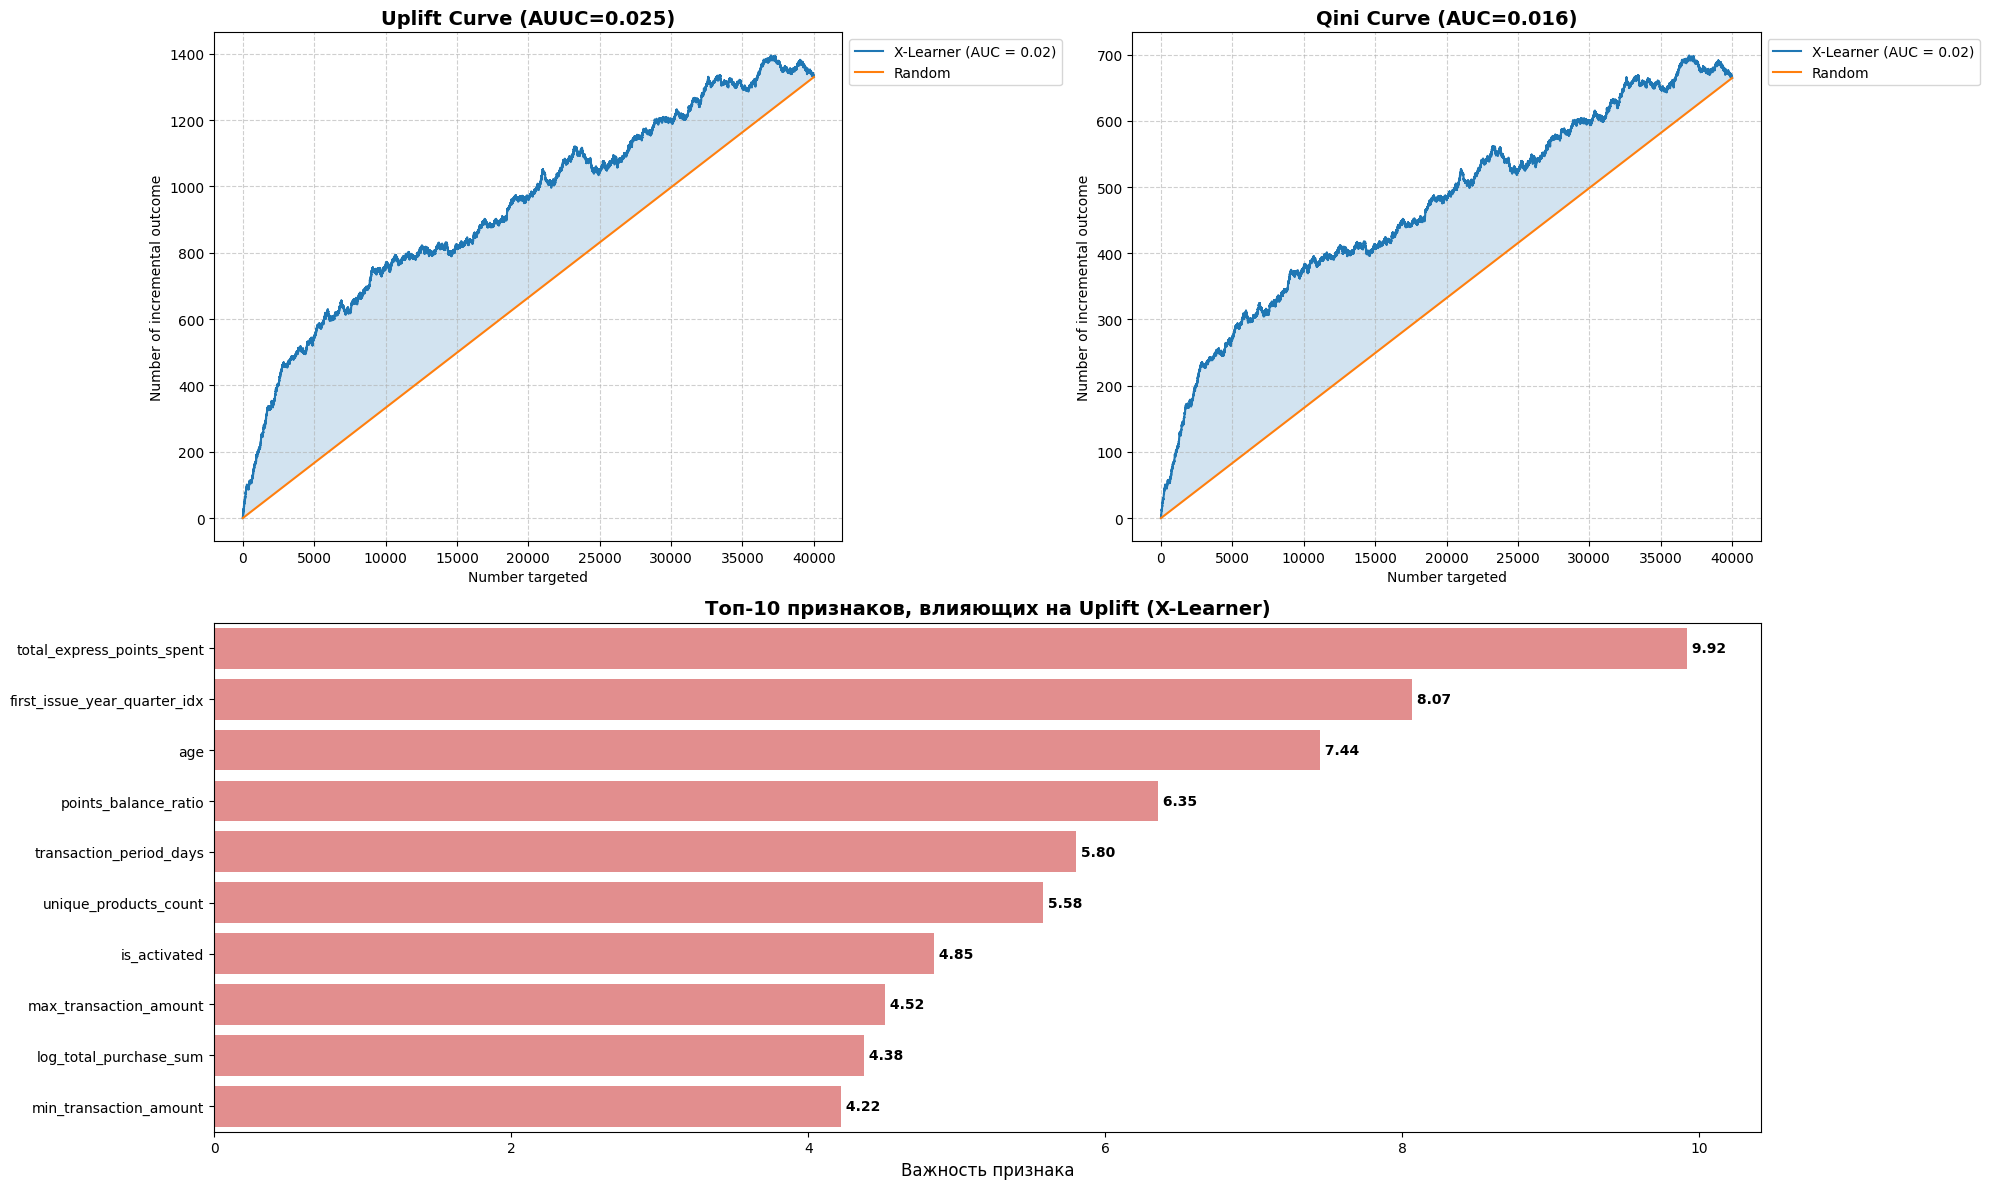

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.viz import plot_uplift_curve, plot_qini_curve

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2)

# Uplift Curve
ax1 = fig.add_subplot(gs[0, 0])
plot_uplift_curve(
    y_true=y_test, 
    uplift=uplift_test, 
    treatment=trmnt_test, 
    perfect=False, 
    ax=ax1,
    name='X-Learner'
)
ax1.set_title(f"Uplift Curve (AUUC={auuc_test:.3f})", fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Qini Curve
ax2 = fig.add_subplot(gs[0, 1])
plot_qini_curve(
    y_true=y_test, 
    uplift=uplift_test, 
    treatment=trmnt_test, 
    perfect=False, 
    ax=ax2,
    name='X-Learner'
)
ax2.set_title(f"Qini Curve (AUC={qini_test:.3f})", fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)

# Важность признаков
ax3 = fig.add_subplot(gs[1, :])
top_k = 10

sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df.head(top_k), 
    color='lightcoral',
    ax=ax3
)

ax3.set_title(f"Топ-{top_k} признаков, влияющих на Uplift (X-Learner)", fontsize=14, fontweight='bold')
ax3.set_xlabel("Важность признака", fontsize=12)
ax3.set_ylabel("")

for i, v in enumerate(feature_importance_df.head(top_k)['importance']):
    ax3.text(v, i, f' {v:.2f}', va='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

## Выводы по этапу моделирования X-Learner

Полученный результат **AUUC (Uplift AUC) = 0.0246** и **Qini AUC = 0.0159** на отложенной выборке является положительным и устойчивым.

Графики Uplift Curve и Qini Curve выпуклые и проходят выше диагонали случайного гадания (модель уловила, что воздействие по-разному влияет на разные сегменты аудитории).

Этап построения X-Learner завершен успешно. Модель демонстрирует способность выделять инкрементальный эффект и имеет прозрачную, интерпретируемую логику.

Принтим фичи для конечной модели:

In [11]:
from IPython.display import Markdown, display

def print_catboost_params_as_python(model, const_name):
    params = model.get_params()

    lines = []
    for k, v in params.items():
        lines.append(f"    {repr(k)}: {repr(v)},")
    body = "\n".join(lines)

    print(f"{const_name} = {{\n{body}\n}}\n")

outcome_model = final_xl.outcome_learner
effect_model = final_xl.effect_learner
propensity_model = final_xl.propensity_learner
print_catboost_params_as_python(outcome_model,    "XL_OUTCOME_CATBOOST_PARAMS")
print_catboost_params_as_python(effect_model,     "XL_EFFECT_CATBOOST_PARAMS")
print_catboost_params_as_python(propensity_model, "XL_PROPENSITY_CATBOOST_PARAMS")

XL_OUTCOME_CATBOOST_PARAMS = {
    'iterations': 147,
    'learning_rate': 0.03633155899517177,
    'depth': 5,
    'l2_leaf_reg': 5.860350130719548,
    'random_seed': 42,
    'verbose': 100,
    'allow_writing_files': False,
    'cat_features': ['first_transaction_quarter', 'gender'],
}

XL_EFFECT_CATBOOST_PARAMS = {
    'iterations': 147,
    'learning_rate': 0.03633155899517177,
    'depth': 5,
    'l2_leaf_reg': 5.860350130719548,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100,
    'allow_writing_files': False,
    'cat_features': ['first_transaction_quarter', 'gender'],
}

XL_PROPENSITY_CATBOOST_PARAMS = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 4,
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False,
    'cat_features': ['first_transaction_quarter', 'gender'],
}



In [12]:
print_catboost_params_as_python(propensity_model, "XL_PROPENSITY_CATBOOST_PARAMS")

XL_PROPENSITY_CATBOOST_PARAMS = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 4,
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False,
    'cat_features': ['first_transaction_quarter', 'gender'],
}

